In [1]:
import numpy as np
import matplotlib.pyplot as plt

from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


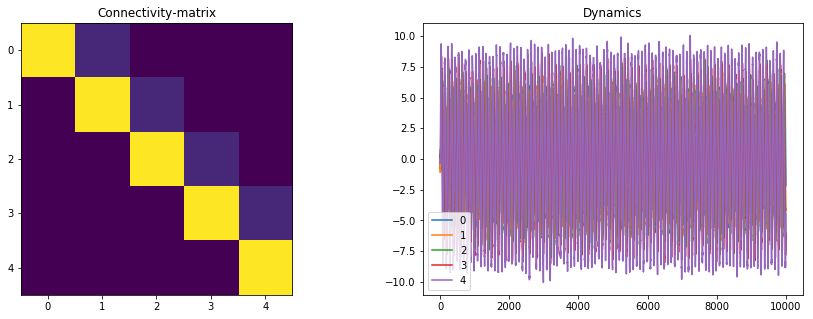

In [2]:
################################
# Create Interaction matrix
################################
alpha = 0.9
N_NODE = 5
M = np.zeros((N_NODE, N_NODE))
for i in range(N_NODE):
    M[i,i] = alpha

for i in range(N_NODE-1):
    M[i, i + 1] = 1 - alpha

################################
# Create data
################################
N_DATA = 10000
data = np.zeros((N_NODE, N_DATA))
for i in range(1, N_DATA):
    data[:, i] = M.dot(data[:, i-1])                    # Propagate signal
    data[N_NODE-1, i] += np.sin(2 * np.pi * i / 100)    # Input to the last node
    data[:, i] += np.random.normal(0, 0.2, 5)           # Noise to all nodes
    
################################
# Plot
################################
    
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].imshow(M)
ax[0].set_title("Connectivity-matrix")
for j in range(N_NODE):
    ax[1].plot(data[j], label=str(j))
ax[1].legend()
ax[1].set_title("Dynamics")
plt.show()

Adding data with properties: 5 processes, 10000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4]

Target: 0 - testing sources [1, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(0, 1)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(1, 1), (2, 1), (3, 1), (4, 1)]
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (2, 1) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(0, 1)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4]

Targe

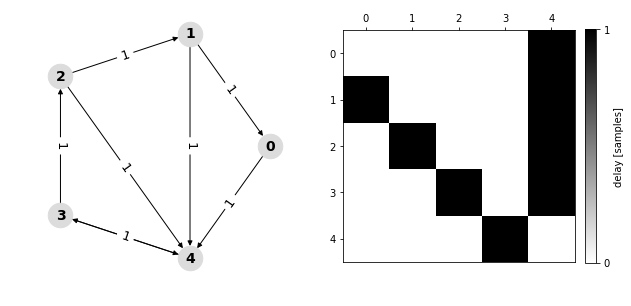

In [3]:
# a) Convert data to ITDxl format
dataIDTxl = Data(data, dim_order='ps')

# b) Initialise analysis object and define settings
network_analysis = MultivariateTE()
settings = {'cmi_estimator': 'JidtGaussianCMI',
            'max_lag_sources': 1,
            'min_lag_sources': 1}

# c) Run analysis
results = network_analysis.analyse_network(settings=settings, data=dataIDTxl)

# d) Plot inferred network to console and via matplotlib
results.print_edge_list(weights='max_te_lag', fdr=False)
plot_network(results=results, weights='max_te_lag', fdr=False)
plt.show()

In [4]:
for i in range(N_NODE):
    rezThis = results.get_single_target(i, fdr=False)
    print("For var", i,
          "sources", [val[0] for val in rezThis['selected_vars_sources']],
          "delays",  [val[1] for val in rezThis['selected_vars_sources']],
          'te', rezThis['selected_sources_te'],
          'p', rezThis['selected_sources_pval'])

For var 0 sources [1] delays [1] te [0.38623293] p [0.002]
For var 1 sources [2] delays [1] te [0.46979368] p [0.002]
For var 2 sources [3] delays [1] te [0.57639871] p [0.002]
For var 3 sources [4] delays [1] te [0.66030238] p [0.002]
For var 4 sources [2, 1, 3, 0] delays [1, 1, 1, 1] te [0.00259699 0.00410539 0.0015859  0.00042568] p [0.002 0.002 0.002 0.002]


### 2. STATISTICAL SANITY CHECK

**TODO:**
1. Construct sets: `[lags], [N_NODE], [noise variances], [period lengths]`
2. Subselect reasonable combinations
3. Run code for each
4. For each run, save: `MAT_TE, MAT_DELAY`
5. Compute:
  * Frequency number correct connection = N as function of N
  * Frequency all correct delays are correct
  * Frequency exists fake connect
  * Ratio MAX_FAKE_TE / AVG_REAL_TE, MAX_FAKE_TE / MIN_REAL_TE
  * Number of fake, number of fake within 10% of MAX_FAKE_TE
  * Effect of noise for fixed everything else, max_lag=1 and max_lag=6
  * Effect of period for fixed everything else, max_lag=1 and max_lag=6